In [2]:
import numpy as np
np.random.seed(42)
import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
import random
random.seed(42)

import os
import subprocess
from tqdm import tqdm
from os import makedirs
from gaussian_renderer import render_lie, render_qtvec
import torchvision
from utils.general_utils import safe_state
from argparse import ArgumentParser
from arguments import ModelParams, PipelineParams, get_combined_args, pose_estimation_params
from gaussian_renderer import GaussianModel
from utils.image_utils import psnr
from utils.loss_utils import EdgeDetection
import numpy as np
from utils.loss_utils import l1_loss, ssim, l2_loss
from copy import deepcopy
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity as LPIPS
import pypose as pp

from scene.dataset_readers import readColmapSceneInfo
from utils.camera_utils import loadCam
from collections import namedtuple
from matplotlib import pyplot as plt


import torch
import math
from diff_gaussian_rasterization_lie_pp import GaussianRasterizationSettings, GaussianRasterizer
from scene.gaussian_model import GaussianModel
from utils.sh_utils import eval_sh

import pickle

from scene.dataset_readers import CameraInfo
from PIL import Image
import mrob
import open3d as o3d

from arguments import  pose_estimation_params
from utils.general_utils import get_expon_lr_func
import cv2
from glob import glob
import copy
import json

In [9]:
import numpy as np
np.array([0,1,2,3,4])[[False, False, True, False, False]].item()

2

In [2]:
def get_number_of_max_iou_iters(num, max_iters=64):
    return num if num < max_iters else max_iters

def get_render_func(camera_type):
    if camera_type == 'qtvec':
        render = render_qtvec
    elif camera_type == 'lietorch':
        render = render_lie
    return render

def get_loss_func(loss_type):
    if loss_type == 'l1':
        loss_func = l1_loss
    elif loss_type == 'l2':
        loss_func = l2_loss
    return loss_func

def get_optimizer_func(optimizer_type):
    if optimizer_type == 'adam':
        optimizer_func = torch.optim.Adam
    return optimizer_func

def image_torch_to_np(image_init):
    norm_image = cv2.normalize(image_init.squeeze().detach().cpu().numpy().transpose(1,2,0), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    norm_image = norm_image.astype(np.uint8)
    return norm_image

class Solver:
    def __init__(self, camera, optimizer_func, camera_pose_estimation_params):
        
        self.pose_optimizer = optimizer_func([{'params': camera.world_view_transform_, 
                                                 'lr': camera_pose_estimation_params.pose_lr_init, "name": "pose"}], 
                                               lr = camera_pose_estimation_params.pose_lr_init)
        self.pose_scheduler_args = get_expon_lr_func(lr_init=camera_pose_estimation_params.pose_lr_init,
                            lr_final=camera_pose_estimation_params.pose_lr_final,
                            lr_delay_steps=camera_pose_estimation_params.pose_lr_delay_steps, 
                            lr_delay_mult=camera_pose_estimation_params.pose_lr_delay_mult,
                            max_steps=camera_pose_estimation_params.pose_lr_max_steps)
        
    def update_learning_rate_pose(self, iteration, factor = 1):
        ''' Learning rate scheduling per step '''
        for param_group in self.pose_optimizer.param_groups:
            if param_group["name"] == "pose":
                if type(self.pose_scheduler_args) == list:
                    lr = self.pose_scheduler_args[iteration] * factor
                else:
                    lr = self.pose_scheduler_args(iteration) * factor
                param_group['lr'] = lr
                return lr
            

def solve_vanilla(cam_info_init, task_info, gaussians, solving_args = None):
    args = namedtuple('args', ['resolution', 'data_device'])
    args = args(task_info['init_render_resolution'], 'cuda')
    pipe = namedtuple('pipe', ['convert_SHs_python', 'compute_cov3D_python', 'debug'])
    pipe = pipe(False, False, False)
    bg_color = [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

    camera_type = task_info['camera_type']
    loss_type = task_info['loss_type']
    optimizer_type = task_info['optimizer_type']

    iterations = task_info['iterations']
    exit_psnr_parameter = task_info['exit_psnr_parameter']

    pose_lr_init = task_info['pose_lr_init']
    pose_lr_final = task_info['pose_lr_final']
    pose_lr_delay_steps = task_info['pose_lr_delay_steps']
    pose_lr_delay_mult = task_info['pose_lr_delay_mult']

    render_func = get_render_func(camera_type)
    loss_func = get_loss_func(loss_type)
    optimizer_func = get_optimizer_func(optimizer_type)

    # camera_gt = loadCam(args=args, id = 0, cam_info=cam_info_gt, resolution_scale=1, camera_type=camera_type)
    camera_init = loadCam(args=args, id = 0, cam_info=cam_info_init, resolution_scale=1, camera_type=camera_type)

    pose_solver = Solver(camera_init, optimizer_func, pose_estimation_params(pose_lr_init, pose_lr_final, pose_lr_delay_steps,
                                                            pose_lr_delay_mult, iterations, False))

    prev_psnr = 1000
    max_psnr = -1
    init_psnr = 0

    lpips = LPIPS(normalize=True).cuda()
    init_qtvec = camera_init.world_view_transform_
    rendering_init = torch.clamp(render_func(camera_init, gaussians, pipe, background)["render"], 0, 1)
    gt_image = camera_init.original_image.cuda()

    # progress_bar = tqdm(range(0, iterations), desc="Optimizing camera " + str(camera_gt.image_name))
    if camera_type == 'lietorch':
        best_viewpoint_cam = torch.nn.Parameter(camera_init.world_view_transform_[0].data.detach().requires_grad_())
    else:
        best_viewpoint_cam = camera_init.world_view_transform_
    converged = False
    counter = 0
    for iteration in range(0, iterations):        
        image = render_func(camera_init, gaussians, pipe, background)["render"]
        image = torch.clamp(image, 0, 1)
        L1 = loss_func(image, gt_image)
        loss_value = L1
        psnr_value = psnr(image, gt_image).mean().item()
        loss_value.backward()

        if iteration == 0:
            loss_init = loss_value.item()

        if psnr_value >= max_psnr:
            max_psnr = psnr_value 
            if camera_type == 'lietorch':
                best_viewpoint_cam = torch.nn.Parameter(camera_init.world_view_transform_[0].data.detach().requires_grad_())
            else:
                best_viewpoint_cam = camera_init.world_view_transform_

        if abs(psnr_value - prev_psnr) <= exit_psnr_parameter:
            counter += 1
            if counter == 3:
                converged = True
                print('Converged. PSNR optimized as: ' \
                + format(init_psnr, '.7f') + ' -> ' + format(max_psnr, '.7f'))
                counter = 0
                # progress_bar.close()
                break

        # progress_bar.set_postfix({"Loss": f"{loss_value.item():.{7}f}", 'PSNR' : f"{psnr_value:.{7}f}"})
        # progress_bar.update()
        prev_psnr = psnr_value
        
        init_psnr = psnr_value if iteration == 0 else init_psnr

        with torch.no_grad():
            if camera_type == 'lietorch':
                camera_init.world_view_transform_.grad = camera_init.world_view_transform.grad[:-1].unsqueeze(0)
            pose_solver.update_learning_rate_pose(iteration)
            pose_solver.pose_optimizer.step()
            pose_solver.pose_optimizer.zero_grad(set_to_none = True)
            if camera_type == 'lietorch':
                camera_init.world_view_transform = torch.nn.Parameter(camera_init.world_view_transform_[0].data.detach().requires_grad_())
    # progress_bar.close()

    if camera_type == 'lietorch':
        camera_init.world_view_transform  = best_viewpoint_cam
    else:
        camera_init.world_view_transform_ = best_viewpoint_cam 

    rendering_result = torch.clamp(render_func(camera_init, gaussians, pipe, background)['render'], 0, 1)
    result_psnr = psnr(rendering_result, gt_image).mean().item()
    result_ssim = ssim(rendering_result, gt_image).mean().item()
    result_lpips = lpips(rendering_result.unsqueeze(0), gt_image.unsqueeze(0)).mean().item()

    init_psnr = psnr(rendering_init, gt_image).mean().item()
    init_ssim = ssim(rendering_init, gt_image).mean().item()
    init_lpips = lpips(rendering_init.unsqueeze(0), gt_image.unsqueeze(0)).mean().item()

    success = 1 if result_psnr > 27 else 0

    return {'qtvec_init':init_qtvec.detach().cpu().numpy(),
            'psnr_init':init_psnr,
            'ssim_init':init_ssim,
            'lpips_init':init_lpips,
            'loss_init':loss_init,
            'image_init':image_torch_to_np(rendering_init),
            'image_gt':image_torch_to_np(gt_image),

            'qtvec_result':best_viewpoint_cam.detach().cpu().numpy(),
            'psnr_result':result_psnr,
            'ssim_result':result_ssim,
            'lpips_result':result_lpips,
            'loss_result':loss_value.item(),
            'image_result':image_torch_to_np(rendering_result),
            'iterations_to_result':iteration,
            'converged':converged,
            'success':success,
            }


def get_solving_func(solving_method):
    if solving_method == 'vanilla':
        solving_func = solve_vanilla
    return solving_func

In [ ]:
def solve_vanilla(cam_info_init, task_info, gaussians, solving_args = None):
    args = namedtuple('args', ['resolution', 'data_device'])
    args = args(task_info['init_render_resolution'], 'cuda')
    pipe = namedtuple('pipe', ['convert_SHs_python', 'compute_cov3D_python', 'debug'])
    pipe = pipe(False, False, False)
    bg_color = [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

    camera_type = task_info['camera_type']
    loss_type = task_info['loss_type']
    optimizer_type = task_info['optimizer_type']

    iterations = task_info['iterations']
    exit_psnr_parameter = task_info['exit_psnr_parameter']

    pose_lr_init = task_info['pose_lr_init']
    pose_lr_final = task_info['pose_lr_final']
    pose_lr_delay_steps = task_info['pose_lr_delay_steps']
    pose_lr_delay_mult = task_info['pose_lr_delay_mult']

    render_func = get_render_func(camera_type)
    loss_func = get_loss_func(loss_type)
    optimizer_func = get_optimizer_func(optimizer_type)

    # camera_gt = loadCam(args=args, id = 0, cam_info=cam_info_gt, resolution_scale=1, camera_type=camera_type)
    camera_init = loadCam(args=args, id = 0, cam_info=cam_info_init, resolution_scale=1, camera_type=camera_type)

    pose_solver = Solver(camera_init, optimizer_func, pose_estimation_params(pose_lr_init, pose_lr_final, pose_lr_delay_steps,
                                                            pose_lr_delay_mult, iterations, False))

    prev_psnr = 1000
    max_psnr = -1
    init_psnr = 0

    lpips = LPIPS(normalize=True).cuda()
    init_qtvec = camera_init.world_view_transform_
    rendering_init = torch.clamp(render_func(camera_init, gaussians, pipe, background)["render"], 0, 1)
    gt_image = camera_init.original_image.cuda()

    # progress_bar = tqdm(range(0, iterations), desc="Optimizing camera " + str(camera_gt.image_name))
    if camera_type == 'lietorch':
        best_viewpoint_cam = torch.nn.Parameter(camera_init.world_view_transform_[0].data.detach().requires_grad_())
    else:
        best_viewpoint_cam = camera_init.world_view_transform_
    converged = False
    counter = 0
    for iteration in range(0, iterations):        
        image = render_func(camera_init, gaussians, pipe, background)["render"]
        image = torch.clamp(image, 0, 1)
        L1 = loss_func(image, gt_image)
        loss_value = L1
        psnr_value = psnr(image, gt_image).mean().item()
        loss_value.backward()

        if iteration == 0:
            loss_init = loss_value.item()

        if psnr_value >= max_psnr:
            max_psnr = psnr_value 
            if camera_type == 'lietorch':
                best_viewpoint_cam = torch.nn.Parameter(camera_init.world_view_transform_[0].data.detach().requires_grad_())
            else:
                best_viewpoint_cam = camera_init.world_view_transform_

        if abs(psnr_value - prev_psnr) <= exit_psnr_parameter:
            counter += 1
            if counter == 3:
                converged = True
                print('Converged. PSNR optimized as: ' \
                + format(init_psnr, '.7f') + ' -> ' + format(max_psnr, '.7f'))
                counter = 0
                # progress_bar.close()
                break

        # progress_bar.set_postfix({"Loss": f"{loss_value.item():.{7}f}", 'PSNR' : f"{psnr_value:.{7}f}"})
        # progress_bar.update()
        prev_psnr = psnr_value
        
        init_psnr = psnr_value if iteration == 0 else init_psnr

        with torch.no_grad():
            if camera_type == 'lietorch':
                camera_init.world_view_transform_.grad = camera_init.world_view_transform.grad[:-1].unsqueeze(0)
            pose_solver.update_learning_rate_pose(iteration)
            pose_solver.pose_optimizer.step()
            pose_solver.pose_optimizer.zero_grad(set_to_none = True)
            if camera_type == 'lietorch':
                camera_init.world_view_transform = torch.nn.Parameter(camera_init.world_view_transform_[0].data.detach().requires_grad_())
    # progress_bar.close()

    if camera_type == 'lietorch':
        camera_init.world_view_transform  = best_viewpoint_cam
    else:
        camera_init.world_view_transform_ = best_viewpoint_cam 

    rendering_result = torch.clamp(render_func(camera_init, gaussians, pipe, background)['render'], 0, 1)
    result_psnr = psnr(rendering_result, gt_image).mean().item()
    result_ssim = ssim(rendering_result, gt_image).mean().item()
    result_lpips = lpips(rendering_result.unsqueeze(0), gt_image.unsqueeze(0)).mean().item()

    init_psnr = psnr(rendering_init, gt_image).mean().item()
    init_ssim = ssim(rendering_init, gt_image).mean().item()
    init_lpips = lpips(rendering_init.unsqueeze(0), gt_image.unsqueeze(0)).mean().item()

    success = 1 if result_psnr > 27 else 0

    return {'qtvec_init':init_qtvec.detach().cpu().numpy(),
            'psnr_init':init_psnr,
            'ssim_init':init_ssim,
            'lpips_init':init_lpips,
            'loss_init':loss_init,
            'image_init':image_torch_to_np(rendering_init),
            'image_gt':image_torch_to_np(gt_image),

            'qtvec_result':best_viewpoint_cam.detach().cpu().numpy(),
            'psnr_result':result_psnr,
            'ssim_result':result_ssim,
            'lpips_result':result_lpips,
            'loss_result':loss_value.item(),
            'image_result':image_torch_to_np(rendering_result),
            'iterations_to_result':iteration,
            'converged':converged,
            'success':success,
            }

In [3]:
room_name = 'apartment_0'
start_frame = 0
end_frame = 4

json_task_paths_template = '/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset/results/tasks/@room_name@/*/@frame_num@/*/*.json'
experiments_base_dir = json_task_paths_template.split('/results/')[0]

ply_path = os.path.join(experiments_base_dir, 
                        'output', room_name, 
                        'point_cloud/iteration_40000/point_cloud.ply')

gaussians = GaussianModel(sh_degree=3)
gaussians.load_ply(ply_path)

frame_nums = np.arange(start_frame, end_frame)
json_task_paths = []
for frame_num in frame_nums:
    json_task_paths += glob(json_task_paths_template.replace('@room_name@', room_name).replace('@frame_num@', str(frame_num).zfill(5)))
json_task_paths = np.array(json_task_paths)

sorted_json_task_paths = json_task_paths[np.argsort([json_task_path.split('/')[-1].split('.json')[0] for json_task_path in json_task_paths])]

for json_task_path in sorted_json_task_paths:

    with open(json_task_path, 'r') as f:
        task_info = json.load(f)

    iou_bin = task_info['iou_bin']
    index = task_info['init_id']
    solving_method = task_info['solving_method']
    solving_args = task_info['solving_method_args']
    solve_func = get_solving_func(solving_method=solving_method)

    with open(task_info['pickle_path'], 'rb') as handle:
        frames_info = pickle.load(handle)

    FovY = frames_info['frames']['FovY']
    FovX = frames_info['frames']['FovX']
    width = frames_info['frames']['width']
    height = frames_info['frames']['height']
    cx = frames_info['frames']['cx']
    cy = frames_info['frames']['cy']

    image_gt = Image.fromarray(frames_info['frames']['image'])
    image_path = frames_info['frames']['img_path']
    image_name = frames_info['img_name']
    R_gt = frames_info['frames']['R']
    t_gt = frames_info['frames']['T']

    # cam_info_gt = CameraInfo(uid=0, R=R_gt, T=t_gt, FovY=FovY, FovX=FovX, image=image_gt,
    #                          image_path=image_path, image_name=image_name, width=width,
    #                          height=height, qvec = None, cx = cx, cy = cy)

    image_init = frames_info['frames']['init_frames_iou_bins'][iou_bin][index]['init_image']
    R_init = frames_info['frames']['init_frames_iou_bins'][iou_bin][index]['R_init']
    t_init = frames_info['frames']['init_frames_iou_bins'][iou_bin][index]['T_init']

    cam_info_init = CameraInfo(uid=0, R=R_init, T=t_init, FovY=FovY, FovX=FovX, image=image_gt,
                            image_path=image_path, image_name=image_name, width=width,
                            height=height, qvec = None, cx = cx, cy = cy)

    iou_value = frames_info['frames']['init_frames_iou_bins'][iou_bin][index]['iou']
    black_pixels_ratio = frames_info['frames']['init_frames_iou_bins'][iou_bin][index]['black_pixels_ratio']
    init_outside = True if black_pixels_ratio > 0.3 else False


    result = solve_func(cam_info_init=cam_info_init, task_info=task_info, gaussians=gaussians, solving_args=solving_args)

    output_result = copy.copy(task_info)
    output_result['image_original_path'] = frames_info['frames']['img_path']
    output_result['width_original'] = frames_info['frames']['width']
    output_result['height_original'] = frames_info['frames']['height']
    output_result['cx_original'] = frames_info['frames']['cx']
    output_result['cy_original'] = frames_info['frames']['cy']
    output_result['FovX'] = frames_info['frames']['FovX']
    output_result['FovY'] = frames_info['frames']['FovY']

    output_result['R_gt'] = frames_info['frames']['R']
    output_result['t_gt'] = frames_info['frames']['T']
    output_result['qvec_gt'] = frames_info['frames']['qvec']
    output_result['black_pixels_ratio'] = black_pixels_ratio
    output_result['init_outside'] = init_outside
    output_result['iou_value'] = iou_value

    output_result = output_result | result


    room_task_dir = os.path.join(results_root, task_info['room_name'])
    # experiment_task_dir = os.path.join(room_task_dir, 
    #                                 str(task_info['camera_type']) + '_' + 
    #                                 str(task_info['loss_type']) + '_' + 
    #                                 str(task_info['optimizer_type']) + '_' + 
    #                                 str(task_info['init_render_resolution']) + '_' + 
    #                                 str(task_info['iterations']) + '_' + 
    #                                 str(task_info['pose_lr_init']) + '_' + 
    #                                 str(task_info['pose_lr_final']) + '_' + 
    #                                 str(task_info['pose_lr_delay_steps']) + '_' + 
    #                                 str(task_info['pose_lr_delay_mult']) + '_' + 
    #                                 str(task_info['exit_psnr_parameter']) + '_' + 
    #                                 str(task_info['solving_method']) + '_' + 
    #                                 str(task_info['solving_method_args']))
    frame_experiment_task_dir = os.path.join(room_task_dir, frame_name, ('%.2f'%iou).replace('.', ''))
    with open(json_task_path.replace('.json', '.pickle'), 'wb') as handle:
        pickle.dump(output_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
import numpy as np
np.arange(2)brea

array([0, 1])

In [7]:
np.array([True, True]).sum()

2

In [ ]:
def process_GT_images(self,opt):
    """apply 2d Blur on Training GT image """

    # get kernel scales
    batch_size = len(self.train_data.all.image)
    if opt.c2f_alternate_2D_mode == "sample":
        scales = opt.c2f_alternate_2D_scale_pool
    else:
        scales = [0.0, 1.0]
    # get kernels
    kernels_dict = dict() # dictionary from scale to kernel
    for sc in scales:
        blur_param = util.interp_schedule(float(self.it/opt.max_iter), opt.blur_2d_c2f_schedule)
        blur_param = torch.tensor(blur_param, device=opt.device)
        blur_param *= sc
        # get kernel

        kernel_width = blur_param * (opt.W + opt.H)/2
        kernel_1d = kernels.get_gaussian_kernel(kernel_width, opt.blur_2d_c2f_kernel_size)

        kernel_1d = kernel_1d.to(device=opt.device,dtype=torch.float32)
        kernel_1d_log = kernel_1d.cpu().detach().numpy()
        fig = plt.figure()
        plt.title(f"2D GT Blur Kernel {sc}")
        plt.plot(kernel_1d_log)
        plt.close(fig)
        kernel_1d = kernel_1d.expand(1,1,-1)

        kernels_dict[sc] = (kernel_1d, kernel_width)

    # generte blurred GT images
    blurred_gt_cached_images = dict()

    for sc, k in kernels_dict.items():
        kernel_1d, kernel_width = k
        # skip kernel if kernel_width too small
        if kernel_width < 0.01:
            images = self.train_data.all.image
        else:
            # perform 2D seperated convolution
            images = self.train_data.all.image.reshape(batch_size*3, opt.H,  opt.W)
            kernel_size = kernel_1d.shape[-1]
            pad_size= (kernel_size //2, kernel_size //2)
            images = torch_F.pad(images, pad_size, mode="replicate")
            images = torch_F.conv1d(images, kernel_1d.expand(opt.H,1,-1), bias=None, stride=1, padding=0, dilation=1, groups=opt.H)
            images = images.permute(0,2,1)
            images = torch_F.pad(images, pad_size, mode="replicate")
            images = torch_F.conv1d(images, kernel_1d.expand(opt.W,1,-1), bias=None, stride=1, padding=0, dilation=1, groups=opt.W)
            images = images.permute(0,2,1).reshape(batch_size, 3, opt.H, opt.W).contiguous()
        blurred_gt_cached_images[sc] = images

    return blurred_gt_cached_images

@torch.no_grad()
def get_edge_mask(self, opt, blurred_gt_cached_images):
    # get kernel scales
    batch_size = len(self.train_data.all.image)
    if opt.c2f_alternate_2D_mode == "sample":
        scales = opt.c2f_alternate_2D_scale_pool
    else:
        scales = [0.0, 1.0]
    # get kernels
    mask_dict = dict() # dictionary from scale to kernel
    # get sobel kernel
    Kx = torch.tensor([[1,0,-1],
                        [2,0,-2],
                        [1,0,-1]], device=opt.device, dtype=torch.float32)[None,None,...].expand(1,3,-1,-1)

    Ky = torch.tensor([[1,2,1],
                        [0,0,0],
                        [-1,-2,-1]], device=opt.device, dtype=torch.float32)[None, None,...].expand(1,3,-1,-1)
    for sc in scales:
        images = blurred_gt_cached_images[sc]
        pad_size = (1,1,1,1)
        images = torch_F.pad(images, pad_size, mode="replicate")
        Gx = torch_F.conv2d(images, Kx, padding=0)
        Gy = torch_F.conv2d(images, Ky, padding=0)
        GG = torch.sqrt(Gx**2 + Gy**2).view(batch_size,opt.H*opt.W)
        if hasattr(opt,"soft_edge_mask") and opt.soft_edge_mask:
            GG_max, _ = GG.max(dim=1,keepdim=True)
            GG_normalized = GG / GG_max
            mask_dict[sc] = GG_normalized
        else:
            GG_mean = GG.mean(dim=(1), keepdim=True)
            thresh = opt.hard_edge_mask_mean_thresh if hasattr(opt, "hard_edge_mask_mean_thresh") else 1.25
            GG_bool = (GG>GG_mean*thresh).to(torch.uint8)
            mask_dict[sc] = GG_bool # batch_size , H*W
    return mask_dict

Converged. PSNR optimized as: 10.8059444 -> 31.5121307


In [62]:
from pytorch3d import io
import torch
from pytorch3d.renderer.cameras import FoVPerspectiveCameras, PerspectiveCameras
from pytorch3d.renderer.points.rasterizer import PointsRasterizer, PointsRasterizationSettings
from pytorch3d.structures import Pointclouds
from pytorch3d.utils import cameras_from_opencv_projection 

from pytorch3d.renderer import (
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    NormWeightedCompositor
)

from utils.graphics_utils import fov2focal, focal2fov

In [63]:
pcd_o3d = o3d.io.read_point_cloud(frames_info['point_cloud_path'])
points_tensor = torch.tensor(np.asarray(pcd_o3d.points)).unsqueeze(0).cuda().float()
colors_tensor = torch.tensor(np.asarray(pcd_o3d.colors)).unsqueeze(0).cuda().float()
points = Pointclouds(points_tensor, features=colors_tensor)

In [64]:
fx = fov2focal(FovX, width)
fy = fov2focal(FovY, height)


camera_matrix = torch.tensor([[fx, 0, cx],
                               [0, fy, cy],
                               [0,0,1]])
# R = [camera.R for camera in cameras]
# tvec = [camera.T for camera in cameras]

camera_p3d = cameras_from_opencv_projection(R = torch.tensor(np.array(R_init)).unsqueeze(0).float(), 
                                            tvec = torch.tensor(np.array(t_init)).unsqueeze(0).float(), 
                                            camera_matrix = camera_matrix.unsqueeze(0).float(),
                                            image_size = torch.tensor([height, 
                                                                        width]).unsqueeze(0).float())

raster_settings = PointsRasterizationSettings(
                image_size=(height, 
                            width), 
                radius = 0.025,
                points_per_pixel = 1
                )
rendered = PointsRasterizer(cameras=camera_p3d.cuda(), raster_settings=raster_settings)(points)
rasterizer = PointsRasterizer(cameras=camera_p3d.cuda(), raster_settings=raster_settings)

renderer = PointsRenderer(
    rasterizer=rasterizer,
    # Pass in background_color to the alpha compositor, setting the background color 
    # to the 3 item tuple, representing rgb on a scale of 0 -> 1, in this case blue
    compositor=NormWeightedCompositor()
)
print(renderer)
images = renderer(points)

PointsRenderer(
  (rasterizer): PointsRasterizer(
    (cameras): PerspectiveCameras()
  )
  (compositor): NormWeightedCompositor()
)


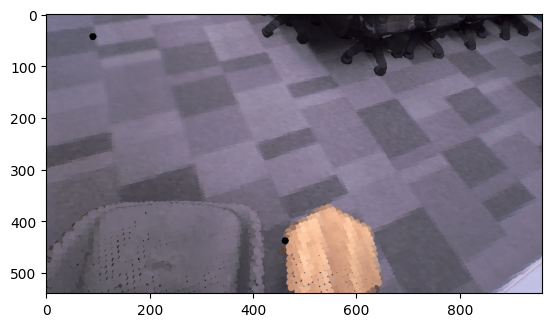

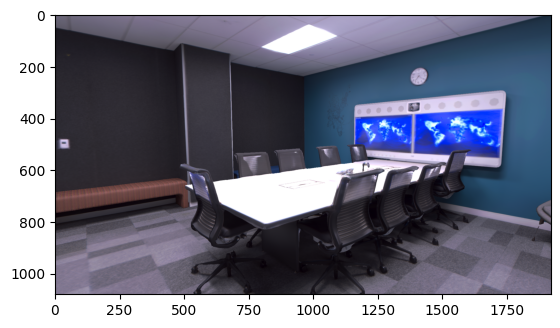

In [65]:
# plt.imshow(result['render'].detach().cpu().numpy().transpose(1,2,0))
# plt.show()
# plt.imshow(images[0].cpu().numpy())
# plt.show()
plt.imshow(image_init)
plt.show()
plt.imshow(image_gt)
plt.show()

In [34]:
def compute_point_cloud_camera_fraction(R, tvec, fx, fy, cx, cy, height, width, points, build_image=False):
    camera_matrix = torch.tensor([[fx, 0, cx],
                               [0, fy, cy],
                               [0,0,1]])
    # R = [camera.R for camera in cameras]
    # tvec = [camera.T for camera in cameras]

    camera_p3d = cameras_from_opencv_projection(R = torch.tensor(np.array(R)).unsqueeze(0).float(), 
                                                tvec = torch.tensor(np.array(tvec)).unsqueeze(0).float(), 
                                                camera_matrix = camera_matrix.unsqueeze(0).float(),
                                                image_size = torch.tensor([height, 
                                                                          width]).unsqueeze(0).float())
    
    raster_settings = PointsRasterizationSettings(
                    image_size=(height, 
                                width), 
                    radius = 0.025,
                    points_per_pixel = 1 
                    )

    # Create a points rasterizer
    

    rasterizer = PointsRasterizer(cameras=camera_p3d.cuda(), raster_settings=raster_settings)
    rasterized = rasterizer(points)

    image = None
    if build_image:
        renderer = PointsRenderer(
            rasterizer=rasterizer,
            # Pass in background_color to the alpha compositor, setting the background color 
            # to the 3 item tuple, representing rgb on a scale of 0 -> 1, in this case blue
            compositor=NormWeightedCompositor()
        )

        image = renderer(points)

    fraction_set = set(torch.unique(rasterized.idx)[1:].tolist())

    return fraction_set, image

In [35]:
set0, image = compute_point_cloud_camera_fraction(R_init, t_init, fx, fy, cx, cy, height, width, points, True)

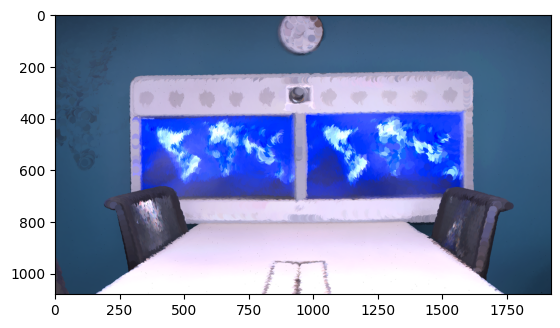

In [37]:
plt.imshow(image.cpu().numpy()[0])

In [ ]:
points_tensor = torch.tensor(np.asarray(pcd_o3d.points)).unsqueeze(0).cuda().float()
colors_tensor = torch.tensor(np.asarray(pcd_o3d.colors)).unsqueeze(0).cuda().float()
points = Pointclouds(points_tensor, features=colors_tensor)

In [ ]:
indices = intersection_indices
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(np.asarray(pcd_o3d.points)[indices])
point_cloud.colors = o3d.utility.Vector3dVector(np.asarray(pcd_o3d.colors)[indices])
point_cloud.normals = o3d.utility.Vector3dVector(np.asarray(pcd_o3d.normals)[indices])

In [ ]:
o3d.io.write_point_cloud('/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset/points_cam_intersection.ply', point_cloud)